In [31]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# 1. Load exclusion mapping
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    Given a session_path and an exclusion mapping dict, return the list of ROI indices to exclude.
    If exclude_dict is not a dict, or session_path not found, return empty list.
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

# ----------------------------------------------------------------------------
# 2. Load session HDF5
# ----------------------------------------------------------------------------
def load_session_data(rec_path):
    """
    Look inside rec_path/MIR_Aligned for any file matching 
    "*aligned_predictions_with_ca_and_dF_F*.h5", load its 'df' key into a DataFrame,
    add metadata columns, and return.
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(
            f"No .h5 with aligned_predictions_with_ca_and_dF_F in {h5_dir}"
        )
    hdf5_file_path = h5_files[0]
    df = pd.read_hdf(hdf5_file_path, key='df')

    norm_path = os.path.normpath(rec_path)
    df['session_id']      = os.path.basename(norm_path)
    df['recording_date']  = os.path.basename(os.path.dirname(norm_path))
    df['experiment']      = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']    = rec_path
    df['file_path']       = hdf5_file_path
    return df

# ----------------------------------------------------------------------------
# 3. Process neuron activity
# ----------------------------------------------------------------------------
def process_neuron_activity(
    df,
    exclude_dict=None,
    manual_exclude_indices=None,
    apply_exclusion=True
):
    """
    1) Determine which ROIs to exclude (from exclude_dict or manual_exclude_indices).
    2) Filter out those dF_F_roi{i} columns.
    3) Compute per-neuron variance, drop bottom 5% by variance.
    4) z-score normalize the remaining rows (neurons).
    Returns:
        normalized : np.ndarray of shape (n_kept_neurons, n_frames)
        filtered_cols : list of column names that were kept
        df.reset_index() : the same DataFrame (with index reset) as df_new
    """
    if apply_exclusion:
        if manual_exclude_indices is not None:
            excluded = manual_exclude_indices
        else:
            excluded = get_excluded_neurons_for_session(
                df.get('session_path', ''), exclude_dict
            )
    else:
        excluded = []

    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    if not neuron_cols:
        return np.empty((0, df.shape[0])), [], df.reset_index()

    activity = df[neuron_cols].values.T  # shape: (n_neurons, n_frames)
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5) if variances.size else 0
    keep = variances > thresh
    filtered = activity[keep, :]         # shape: (n_kept_neurons, n_frames)
    filtered_cols = [col for i, col in enumerate(neuron_cols) if keep[i]]
    normalized = zscore(filtered, axis=1, nan_policy='omit') if filtered.size else filtered
    return normalized, filtered_cols, df.reset_index()

# ----------------------------------------------------------------------------
# 4. Evaluate COM interaction per neuron
# ----------------------------------------------------------------------------
def evaluate_com_interaction_per_cell(
    rec_path,
    exclude_dict=None,
    thresh_mm=30.0,
    pre_ms=200,
    post_ms=200,
    max_frames=300,
    top_n=5
):
    """
    计算 COM 距离 < thresh_mm 时刻，对最相关的 top_n 个神经元做 event-triggered average。

    参数
    ----
    rec_path : str
        会话数据文件夹路径，函数内部会调用 load_session_data(rec_path) 得到 df。
    exclude_dict : dict or None
        神经元排除字典，传给 process_neuron_activity 用。
    thresh_mm : float, default 30.0
        当两只动物 COM 距离 < thresh_mm 时视为“靠近”。
    pre_ms : int, default 200
        事件触发前截取的时长（ms）。
    post_ms : int, default 200
        事件触发后截取的时长（ms）。
    max_frames : int, default 300
        只取前 max_frames 帧来做分析。
    top_n : int, default 5
        先用 Pearson r 排序，取 |r| 最大的 top_n 个神经元做 PSTH。

    返回
    ----
    summary_df : pd.DataFrame
        包含 top_n 每个神经元的以下列：
          - cell_name
          - pearson_r
          - pearson_p
          - n_events
          - psth_peak
          - psth_baseline
    """
    # ——————— (1) 加载数据 & 只保留前 max_frames 帧 ———————
    df = load_session_data(rec_path)

    # 如果 timestamp_ms_mini 是索引而非列，则先 reset_index
    if 'timestamp_ms_mini' not in df.columns:
        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        else:
            raise KeyError("DataFrame 中缺少 'timestamp_ms_mini' 列或索引")

    df = df.iloc[:max_frames].reset_index(drop=True)

    # ——————— (2) 神经元信号处理 —— z-score & 过滤 ———————
    neuron_norm, neuron_cols, df_new = process_neuron_activity(
        df,
        exclude_dict=exclude_dict,
        manual_exclude_indices=None,
        apply_exclusion=True
    )
    # neuron_norm: (n_kept_neurons, max_frames)
    neuron_norm_T = neuron_norm.T  # shape: (max_frames, n_kept_neurons)
    pop_rate = neuron_norm_T.mean(axis=1) if neuron_norm_T.size else np.zeros(max_frames)

    # 这里用 df_new 来计算 COM
    time_ms = df_new['timestamp_ms_mini'].values  # (max_frames,)
    dt = np.median(np.diff(time_ms))              # 每帧约多少 ms

    # ——————— (3) 识别 COM 前缀 & 计算平滑 COM 与距离 ———————
    com_prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com')})
    com_cols = [f'{p}_{axis}' for p in com_prefixes for axis in ('x','y','z')]
    # 5-point moving average
    smoothed = df_new[com_cols].rolling(window=5, center=True).mean()

    if len(com_prefixes) >= 2:
        p1, p2 = com_prefixes[0], com_prefixes[1]
        # 原始 distance
        dx0 = df_new[f'{p1}_x'] - df_new[f'{p2}_x']
        dy0 = df_new[f'{p1}_y'] - df_new[f'{p2}_y']
        dz0 = df_new[f'{p1}_z'] - df_new[f'{p2}_z']
        dist_raw = np.sqrt(dx0**2 + dy0**2 + dz0**2)

        # 平滑 distance
        dx = smoothed[f'{p1}_x'] - smoothed[f'{p2}_x']
        dy = smoothed[f'{p1}_y'] - smoothed[f'{p2}_y']
        dz = smoothed[f'{p1}_z'] - smoothed[f'{p2}_z']
        dist_sm = np.sqrt(dx**2 + dy**2 + dz**2)

        # 用原始 dist 填充平滑中的 NaN
        dist_sm = dist_sm.fillna(dist_raw)
        dist_arr = dist_sm.values
    else:
        dist_arr = np.zeros(max_frames)

    
    # ====== 插入叠加图 ======
    plt.figure(figsize=(8,3))
    plt.plot(time_ms, dist_arr, label="dist_sm")
    plt.twinx()
    plt.plot(time_ms, pop_rate, color='tab:orange', label="pop_rate")
    plt.legend(loc='upper right')
    plt.xlabel("Time (ms)")
    plt.title(f"dist_sm vs pop_rate (first {len(time_ms)} frames)")
    plt.tight_layout()
    plt.show()
    # ====== 插入叠加图结束 ======

    # ——————— (4) 全局 Pearson r 排名前 top_n 个神经元 ———————
    pearson_list = []
    if neuron_norm_T.size:
        for ci, cname in enumerate(neuron_cols):
            r_i, p_i = pearsonr(dist_arr, neuron_norm_T[:, ci])
            pearson_list.append((cname, r_i, p_i))
        pearson_list.sort(key=lambda x: abs(x[1]), reverse=True)
        top_cells = pearson_list[:top_n]
    else:
        top_cells = []

    if top_cells:
        print("\nTop cells by |Pearson r| with COM distance:")
        for cname, r_i, p_i in top_cells:
            print(f"  {cname: <15}  r = {r_i:.3f}, p = {p_i:.3e}")
    else:
        print("\nNo neurons available for Pearson correlation.")

    # ——————— (5) 全局散点：COM dist vs pop_rate ———————
    plt.figure(figsize=(5,4))
    plt.scatter(dist_arr, pop_rate, s=5, alpha=0.3, color='tab:gray')
    plt.xlabel("COM distance (mm)")
    plt.ylabel("Population rate (z-scored mean)")
    if neuron_norm_T.size:
        r_all, p_all = pearsonr(dist_arr, pop_rate)
        plt.title(f"Global POPRATE r={r_all:.2f}")
    else:
        plt.title("Global POPRATE (no neurons)")
    plt.tight_layout()
    plt.show()

    # ——————— (6) 距离分箱 vs 平均 pop_rate 可视化 ———————
    bin_size = 10.0
    bins = np.arange(0, np.ceil(dist_arr.max()/bin_size)*bin_size + 1, bin_size)
    bin_idx = np.digitize(dist_arr, bins)
    mean_rate = [
        pop_rate[bin_idx == i].mean() if neuron_norm_T.size else 0
        for i in range(1, len(bins))
    ]
    plt.figure(figsize=(5,3))
    plt.plot(bins[:-1], mean_rate, marker='o', color='tab:blue')
    plt.xlabel("Distance bin (mm)")
    plt.ylabel("Mean pop. rate")
    plt.title("Binned COM dist vs pop rate")
    plt.tight_layout()
    plt.show()

    # ——————— (7) 找到“跨过阈值”事件时刻 ———————
    pct = 10
    move_threshold = np.percentile(dist_arr, pct)
    crossings = np.where((dist_arr[:-1] >= move_threshold) & (dist_arr[1:] < move_threshold))[0] + 1
    print(f"Using {pct}th percentile ({move_threshold:.2f} mm) as threshold, #events = {len(crossings)}")

    # 计算 event-triggered 窗口对应的帧数
    pre_frames  = int(pre_ms / dt)
    post_frames = int(post_ms / dt)
    win_len     = pre_frames + post_frames

    if len(crossings) < 5:
        print("Warning: crossing events < 5, PSTH 可能不稳定。")

    # ——————— (8) 对 top_n 细胞做 event-triggered average ———————
    summary = []
    epochs_dict = {cname: [] for (cname, _, _) in top_cells}

    for idx in crossings:
        start = idx - pre_frames
        end   = idx + post_frames
        if start < 0 or end > max_frames or not neuron_norm_T.size:
            continue
        snippet = neuron_norm_T[start:end, :]  # shape: (win_len, n_kept_neurons)
        for cname, _, _ in top_cells:
            ci = neuron_cols.index(cname)
            epochs_dict[cname].append(snippet[:, ci])

    # ——————— (9) 汇总每个细胞的 PSTH —— 计算峰值 & 基线 ———————
    t_win = np.linspace(-pre_ms, post_ms, win_len)  # shape: (win_len,)

    for (cname, r_i, p_i) in top_cells:
        arr_list = epochs_dict[cname]
        if len(arr_list) == 0:
            summary.append({
                'cell_name': cname,
                'pearson_r': r_i,
                'pearson_p': p_i,
                'n_events': 0,
                'psth_peak': np.nan,
                'psth_baseline': np.nan
            })
            continue

        epochs = np.vstack(arr_list)  # (n_events, win_len)
        mean_psth = epochs.mean(axis=0)  # (win_len,)

        # — (9a) 绘制 PSTH 波形 ——
        plt.figure(figsize=(4,3))
        plt.plot(t_win, mean_psth, color='tab:orange')
        plt.axvline(0, color='k', linestyle='--')
        plt.xlabel("Time relative to COM<thr (ms)")
        plt.ylabel("z-score firing")
        plt.title(f"{cname} (n={epochs.shape[0]})")
        plt.tight_layout()
        plt.show()

        # — (9b) 计算基线 & 峰值指标 ——————
        bl_window_end = -pre_ms + 50  # 基线区间为 [-pre_ms, -pre_ms+50)
        bl_mask = (t_win >= -pre_ms) & (t_win < bl_window_end)
        bl_vals = mean_psth[bl_mask]
        if bl_vals.size > 0:
            psth_baseline = bl_vals.mean()
        else:
            psth_baseline = np.nan

        peak_mask = (t_win >= -25) & (t_win <= 25)
        peak_vals = mean_psth[peak_mask]
        if peak_vals.size > 0:
            psth_peak = peak_vals.max()
        else:
            psth_peak = np.nan

        summary.append({
            'cell_name': cname,
            'pearson_r': r_i,
            'pearson_p': p_i,
            'n_events': epochs.shape[0],
            'psth_peak': psth_peak,
            'psth_baseline': psth_baseline
        })

    summary_df = pd.DataFrame(summary)
    return summary_df



=== Processing /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/ ===


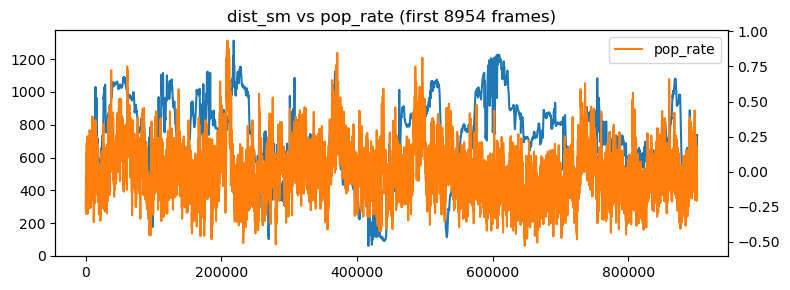


Top cells by |Pearson r| with COM distance:
  dF_F_roi30       r = 0.250, p = 1.591e-127
  dF_F_roi2        r = 0.247, p = 2.491e-124
  dF_F_roi13       r = 0.244, p = 5.040e-121
  dF_F_roi4        r = 0.237, p = 1.570e-114
  dF_F_roi9        r = -0.181, p = 1.179e-66


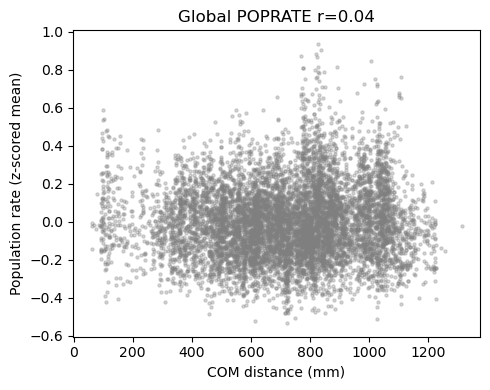

/tmp/ipykernel_880311/3194915215.py:246: RuntimeWarning: Mean of empty slice.
  pop_rate[bin_idx == i].mean() if neuron_norm_T.size else 0
/home/lq53/miniconda3/envs/bbop241209_clone/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


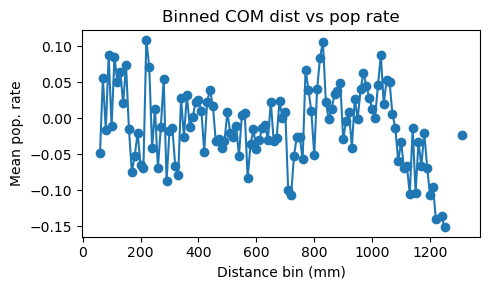

Using 10th percentile (407.11 mm) as threshold, #events = 48


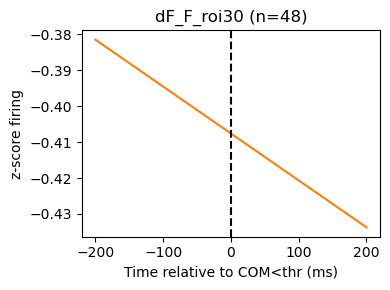

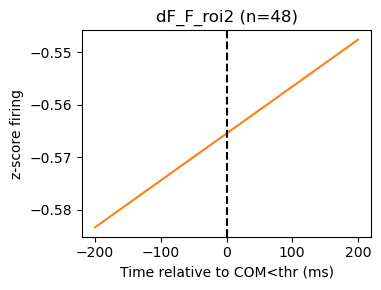

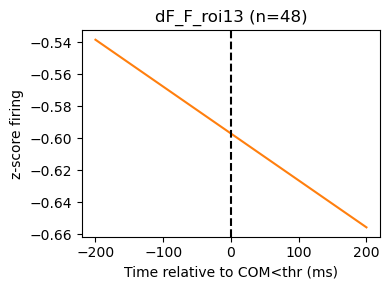

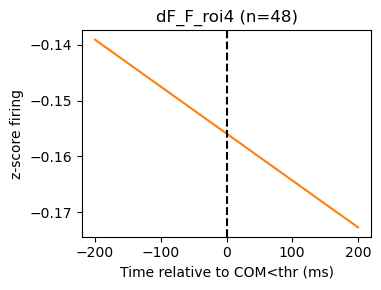

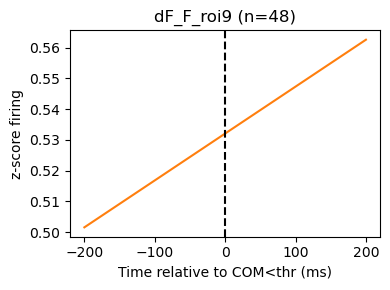

 cell_name  pearson_r     pearson_p  n_events  psth_peak  psth_baseline
dF_F_roi30   0.249874 1.590526e-127        48        NaN      -0.381547
 dF_F_roi2   0.246774 2.490703e-124        48        NaN      -0.583309
dF_F_roi13   0.243519 5.039578e-121        48        NaN      -0.538378
 dF_F_roi4   0.236981 1.570432e-114        48        NaN      -0.139123
 dF_F_roi9  -0.180787  1.179485e-66        48        NaN       0.501560

=== Processing /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/ ===


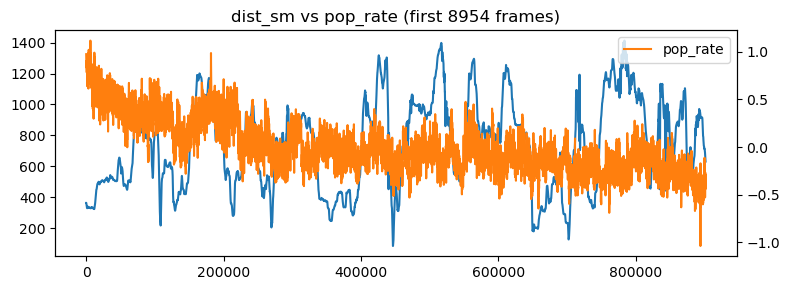


Top cells by |Pearson r| with COM distance:
  dF_F_roi4        r = -0.233, p = 3.071e-110
  dF_F_roi36       r = 0.232, p = 5.070e-110
  dF_F_roi42       r = -0.222, p = 3.267e-100
  dF_F_roi8        r = 0.213, p = 1.070e-92
  dF_F_roi5        r = -0.204, p = 1.774e-84


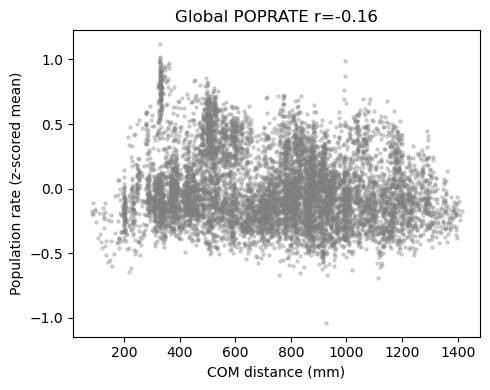

/tmp/ipykernel_880311/3194915215.py:246: RuntimeWarning: Mean of empty slice.
  pop_rate[bin_idx == i].mean() if neuron_norm_T.size else 0
/home/lq53/miniconda3/envs/bbop241209_clone/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


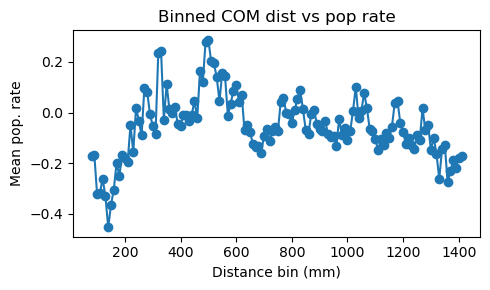

Using 10th percentile (351.58 mm) as threshold, #events = 13


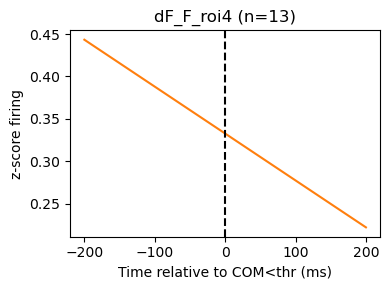

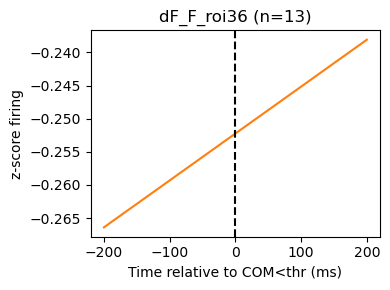

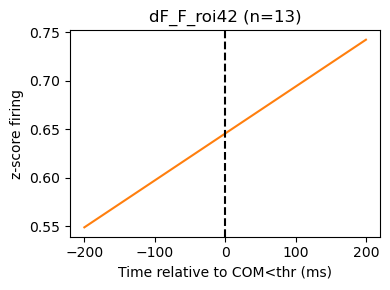

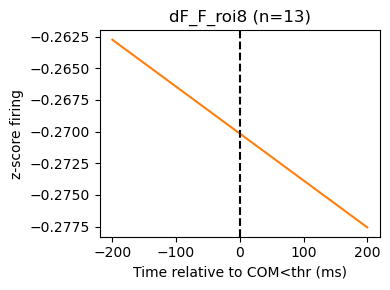

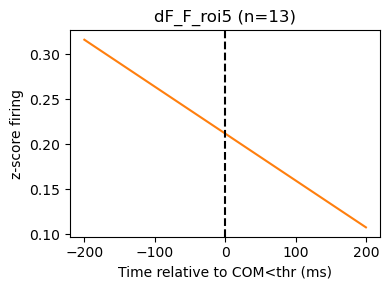

 cell_name  pearson_r     pearson_p  n_events  psth_peak  psth_baseline
 dF_F_roi4  -0.232547 3.071093e-110        13        NaN       0.443333
dF_F_roi36   0.232319 5.069730e-110        13        NaN      -0.266402
dF_F_roi42  -0.221802 3.266827e-100        13        NaN       0.548988
 dF_F_roi8   0.213358  1.069734e-92        13        NaN      -0.262742
 dF_F_roi5  -0.203683  1.773583e-84        13        NaN       0.316200

=== Processing /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/ ===


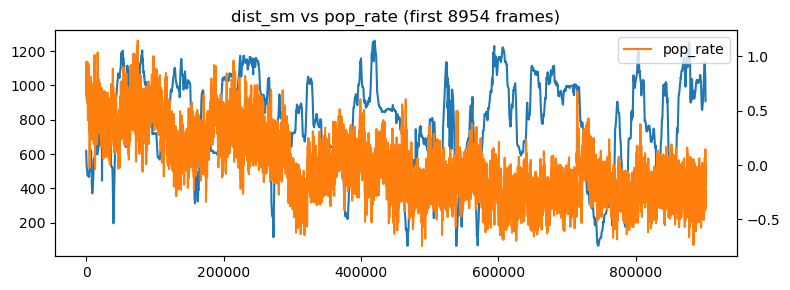


Top cells by |Pearson r| with COM distance:
  dF_F_roi21       r = -0.141, p = 4.841e-41
  dF_F_roi10       r = -0.136, p = 1.937e-38
  dF_F_roi16       r = 0.128, p = 3.254e-34
  dF_F_roi26       r = -0.122, p = 5.924e-31
  dF_F_roi13       r = 0.120, p = 5.204e-30


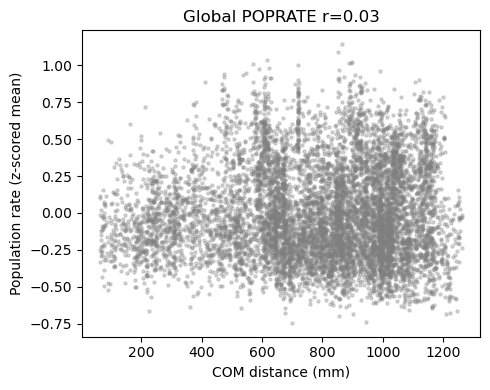

/tmp/ipykernel_880311/3194915215.py:246: RuntimeWarning: Mean of empty slice.
  pop_rate[bin_idx == i].mean() if neuron_norm_T.size else 0
/home/lq53/miniconda3/envs/bbop241209_clone/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


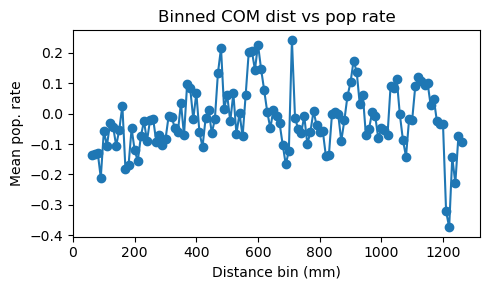

Using 10th percentile (379.19 mm) as threshold, #events = 15


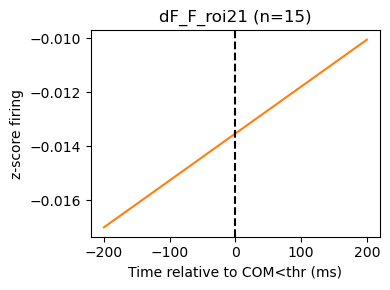

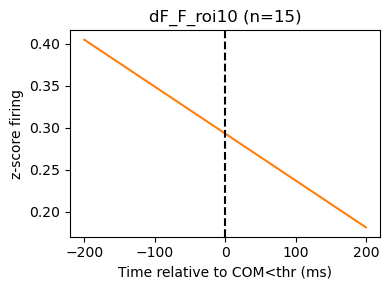

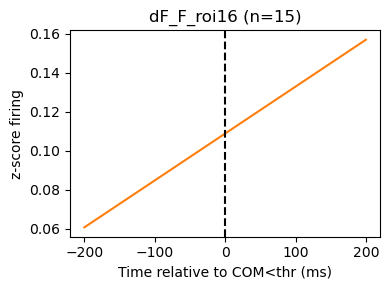

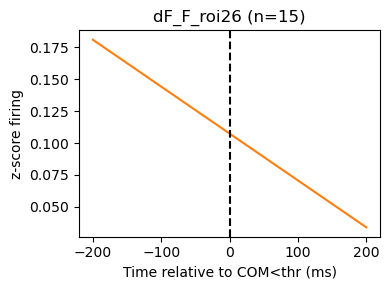

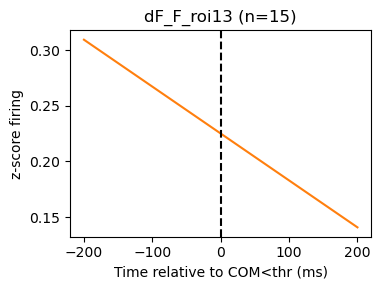

 cell_name  pearson_r    pearson_p  n_events  psth_peak  psth_baseline
dF_F_roi21  -0.141095 4.841345e-41        15        NaN      -0.017002
dF_F_roi10  -0.136390 1.936530e-38        15        NaN       0.404540
dF_F_roi16   0.128374 3.254143e-34        15        NaN       0.060694
dF_F_roi26  -0.121821 5.924480e-31        15        NaN       0.181029
dF_F_roi13   0.119856 5.203526e-30        15        NaN       0.309539


In [32]:
session_paths = [
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/",
]

exclude_dict = "/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json"

all_summaries = []
for path in session_paths:
    print(f"\n=== Processing {path} ===")
    summary_df = evaluate_com_interaction_per_cell(
        rec_path=path,
        exclude_dict=exclude_dict,
        thresh_mm=60.0,
        pre_ms=200,
        post_ms=200,
        max_frames=12600,
        top_n=5
    )
    print(summary_df.to_string(index=False))
    all_summaries.append((path, summary_df))
